# Custom Neural Network Design for Early Sepsis Prediction

This notebook formalizes the architecture, training strategy, and evaluation framework 
for predicting sepsis onset 2h, 4h, and 6h in advance using time-series laboratory data.

We explicitly define:
- Input tensor structure
- Model architecture
- Initialization strategy
- Training strategy
- Evaluation metrics
- Justification grounded in course concepts

Three separate models will be trained for 2h, 4h, and 6h horizons to ensure 
clarity, interpretability, and clean feature importance analysis.

## STAGE ALIGNMENT

Input:
- Processed time-series dataset (Parquet)
- Patient-level split preserved
- Engineered labels (2h, 4h, 6h)

Output:
- Verified tensor structure
- Confirmed class imbalance
- Finalized architecture design
- Locked training strategy

Next Stage Dependency:
- Implementation of LSTM-based neural network
- Weighted training with early stopping

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("CUDA Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2050


In [2]:
from pathlib import Path
import pandas as pd

# Define project root relative to notebook
PROJECT_ROOT = Path("..")
PROCESSED_PATH = PROJECT_ROOT / "Data" / "processed"

print("Processed Path Exists:", PROCESSED_PATH.exists())
print("Files in Processed Folder:")
print(list(PROCESSED_PATH.iterdir()))

Processed Path Exists: True
Files in Processed Folder:
[WindowsPath('../Data/processed/.gitkeep'), WindowsPath('../Data/processed/sepsis_labeled_2h.pkl'), WindowsPath('../Data/processed/sepsis_labeled_4h.pkl'), WindowsPath('../Data/processed/sepsis_labeled_6h.pkl')]


## Dataset Loading — 2h Horizon

We begin with the 2-hour labeled dataset to validate structural integrity before 
constructing temporal sequences. This horizon is the most imbalanced and 
clinically challenging, making it an appropriate starting point. 

This step verifies dataset dimensions, patient count, and feature structure 
before introducing sequence modeling complexity.

In [3]:
# Load 2h labeled dataset
df_2h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_2h.pkl")

print("Shape:", df_2h.shape)
print("Unique Patients:", df_2h["id"].nunique())
print("Columns:", len(df_2h.columns))

df_2h.head()

Shape: (602568, 48)
Unique Patients: 1275
Columns: 48


,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,...,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,label_2h
0,12292,0,0.0,0.0,0.190898,0.424464,0.301015,-0.168117,-0.275272,1.879692,...,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
1,12292,0,0.0,0.5,0.157654,0.667394,0.301015,-0.168117,-0.275272,1.708485,...,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
2,12292,0,0.0,1.0,0.024678,0.618808,0.301015,-0.732387,1.003408,2.050899,...,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
3,12292,0,0.0,1.5,-0.208030,0.278706,0.301015,-0.732387,1.003408,1.366071,...,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
4,12292,0,0.0,2.0,-0.108298,-0.352912,0.301015,-0.732387,1.094023,1.537278,...,2.719423,0.010733,-0.710447,0.452120,-0.023852,0.117472,0.317126,0.061715,0.371047,0


### Structural Insight

The dataset contains 602,568 time-indexed observations across 1,275 patients.
Each row represents a physiological snapshot at a specific timestep.

Since sepsis is a progressive condition rather than a sudden event,
row-wise data must be transformed into temporal sequences before
training a neural network model.

## Label Distribution — 2h

We verify class imbalance before sequence construction, 
as it directly affects loss design and evaluation strategy.

In [4]:
positive_rate = df_2h["label_2h"].mean()
positive_count = df_2h["label_2h"].sum()
total_count = len(df_2h)

print("Total Samples:", total_count)
print("Positive Samples:", int(positive_count))
print("Positive Rate:", positive_rate)

Total Samples: 602568
Positive Samples: 1480
Positive Rate: 0.0024561543261507413


## Temporal Structure Analysis

Before constructing sliding windows, we verify:
- Timestep resolution
- Consistency of spacing
- Number of observations per patient

This ensures the chosen sequence length is structurally valid.

In [5]:
df_2h.sort_values(["id", "timestep"]).groupby("id")["timestep"].head(10).head(20)

26734     0.0
26735     0.5
26736     1.0
26737     1.5
26738     2.0
26739     2.5
26740     3.0
26741     3.5
26742     4.0
26743     4.5
341361    0.0
341362    0.5
341363    1.0
341364    1.5
341365    2.0
341366    2.5
341367    3.0
341368    3.5
341369    4.0
341370    4.5
Name: timestep, dtype: float64

In [6]:
df_2h["timestep_diff"] = df_2h.groupby("id")["timestep"].diff()
df_2h["timestep_diff"].dropna().value_counts().head()

timestep_diff
0.5    601293
Name: count, dtype: int64

In [7]:
records_per_patient = df_2h.groupby("id").size()

print("Min records per patient:", records_per_patient.min())
print("Median records per patient:", records_per_patient.median())
print("Max records per patient:", records_per_patient.max())

Min records per patient: 32
Median records per patient: 209.0
Max records per patient: 5424


### Temporal Structure Insight

Timestep increases consistently in increments of 0.5, confirming uniform sampling.
This means each step represents 30 minutes.

All patients have at least 32 observations, with a median of 209 and a maximum of 5,424.
Therefore, every patient has sufficient history to construct temporal windows.

Given 0.5-hour resolution:
- 12 timesteps = 6 hours of history
- 24 timesteps = 12 hours of history

This validates the feasibility of fixed-length sliding windows for sequence modeling.

## Sequence Construction — 2h Model

We construct fixed-length sliding windows of 12 timesteps (6 hours history).
Each training sample consists of:

- Input: 12 consecutive timesteps of physiological features
- Target: label_2h at the final timestep of the window

Patient boundaries are strictly preserved to prevent leakage.

In [8]:
feature_cols = df_2h.columns.drop(["id", "sepsis", "severity", "label_2h", "timestep_diff"])
print("Number of features:", len(feature_cols))
feature_cols[:10]

Number of features: 44


Index(['timestep', 'respiratory_minute_volume', 'heart_rate', 'leukocytes',
       'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph',
       'bilirubin', 'blood_urea_nitrogen'],
      dtype='object')

### Feature Structure Insight

After excluding identifiers and target-related columns, 44 physiological 
features remain available for modeling.

The timestep variable is retained as a feature, allowing the model to 
learn relative temporal positioning within each sequence.

These 44 variables will form the feature dimension of each timestep 
within the constructed sliding windows.

In [9]:
SEQUENCE_LENGTH = 12  # 12 timesteps = 6 hours history

X_sequences = []
y_sequences = []

for patient_id, group in df_2h.groupby("id"):
    group = group.sort_values("timestep")
    
    features = group[feature_cols].values
    labels = group["label_2h"].values
    
    for i in range(len(group) - SEQUENCE_LENGTH + 1):
        X_sequences.append(features[i:i+SEQUENCE_LENGTH])
        y_sequences.append(labels[i+SEQUENCE_LENGTH-1])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print("X shape:", X_sequences.shape)
print("y shape:", y_sequences.shape)

X shape: (588543, 12, 44)
y shape: (588543,)


In [10]:
positive_rate_seq = y_sequences.mean()
positive_count_seq = y_sequences.sum()

print("Total Sequences:", len(y_sequences))
print("Positive Sequences:", int(positive_count_seq))
print("Positive Rate (Sequence Level):", positive_rate_seq)

Total Sequences: 588543
Positive Sequences: 1480
Positive Rate (Sequence Level): 0.0025146845685022163


### Sequence-Level Imbalance Insight

After temporal windowing, 588,543 training sequences were generated.

Positive sequences: 1,480  
Positive rate ≈ 0.251%

Class imbalance remains extreme and nearly unchanged after window construction.

Therefore:
- Weighted loss is mandatory.
- Accuracy remains misleading.
- ROC-AUC and PR-AUC will be primary evaluation metrics.

## Patient-Level Split (2h)

We split patients before sequence construction to prevent temporal leakage 
across train and test sets.

In [11]:
from sklearn.model_selection import train_test_split

patient_ids = df_2h["id"].unique()

train_ids, test_ids = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42
)

train_df = df_2h[df_2h["id"].isin(train_ids)]
test_df = df_2h[df_2h["id"].isin(test_ids)]

print("Train Patients:", len(train_ids))
print("Test Patients:", len(test_ids))

Train Patients: 1020
Test Patients: 255


### Split Insight

1,020 patients in training and 255 in testing.
The split is performed at the patient level, ensuring no temporal leakage
between training and evaluation data.

## Sequence Construction — Train & Test
Sliding windows are constructed independently for train and test sets.

In [12]:
def build_sequences(df, feature_cols, label_col, seq_len=12):
    X_seq, y_seq = [], []
    
    for pid, group in df.groupby("id"):
        group = group.sort_values("timestep")
        features = group[feature_cols].values
        labels = group[label_col].values
        
        for i in range(len(group) - seq_len + 1):
            X_seq.append(features[i:i+seq_len])
            y_seq.append(labels[i+seq_len-1])
    
    return np.array(X_seq), np.array(y_seq)


X_train, y_train = build_sequences(train_df, feature_cols, "label_2h")
X_test, y_test = build_sequences(test_df, feature_cols, "label_2h")

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (471469, 12, 44)
Test shape: (117074, 12, 44)


### Sequence Split Insight

471,469 training sequences and 117,074 testing sequences were generated.
Train and test tensors are fully separated at the patient level,
eliminating temporal and subject leakage.

## Feature Scaling

We standardize features using training data statistics only,
then apply the same transformation to the test set.

In [13]:
from sklearn.preprocessing import StandardScaler

# reshape for scaling (combine sequence dimension temporarily)
num_train, seq_len, num_features = X_train.shape

scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

# Fit only on training
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_train, seq_len, num_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], seq_len, num_features)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

Scaled train shape: (471469, 12, 44)
Scaled test shape: (117074, 12, 44)


### Scaling Insight

Features were standardized using training data statistics only.
Tensor structure (12, 44) was preserved after reshaping.

The model will now receive numerically stable inputs,
which is essential for effective gradient-based learning.

## PyTorch Tensor Conversion

Convert scaled NumPy arrays into PyTorch tensors 
for model training.

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("Train tensor shape:", X_train_tensor.shape)
print("Test tensor shape:", X_test_tensor.shape)
print("Device:", device)

Train tensor shape: torch.Size([471469, 12, 44])
Test tensor shape: torch.Size([117074, 12, 44])
Device: cuda


## Dataset & DataLoader

Create PyTorch Dataset and DataLoader for mini-batch training.

In [15]:
from torch.utils.data import Dataset, DataLoader

class SepsisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 256

train_dataset = SepsisDataset(X_train_tensor, y_train_tensor)
test_dataset = SepsisDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

Train batches: 1842
Test batches: 458


## LSTM Model Definition (2h)
Single-layer LSTM followed by dense layers for binary classification.

In [20]:
import torch.nn as nn

class SepsisLSTM(nn.Module):
    def __init__(self, input_size=44, hidden_size=64, dropout=0.3):
        super(SepsisLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param.data)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # Last timestep
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [21]:
model = SepsisLSTM().to(device)
print(model)

SepsisLSTM(
  (lstm): LSTM(44, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Architecture Rationale

- **LSTM (64 units):** Chosen to model temporal dependencies in physiological progression. 
  64 units balance expressive capacity and overfitting risk given ~588k sequences.

- **Dropout (0.3):** Regularization to reduce variance due to extreme class imbalance 
  and long patient trajectories.

- **Dense (32 units, ReLU):** Introduces non-linearity after temporal encoding 
  while keeping parameter count controlled.

- **Sigmoid Output (1 unit):** Binary probability prediction for sepsis onset.

Initialization:
- Xavier for input weights → stable gradient flow.
- Orthogonal for recurrent weights → preserves long-term memory dynamics.

## Weighted Loss Definition

Due to extreme class imbalance (~0.25% positives), 
we apply class weighting in the loss function.

Positive weight is computed from the training data only.

In [22]:
# Compute positive class weight from training sequences
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count

pos_weight_value = neg_count / pos_count

print("Positive samples (train):", int(pos_count))
print("Negative samples (train):", int(neg_count))
print("Computed pos_weight:", pos_weight_value)

Positive samples (train): 1190
Negative samples (train): 470279
Computed pos_weight: 395.1924369747899


In [23]:
import torch.nn.functional as F

pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training Strategy — 2h Model

- Optimizer: Adam (lr=1e-3)
- Loss: Weighted BCEWithLogitsLoss
- Batch size: 256
- Max epochs: 20
- Early stopping based on validation ROC-AUC (patience = 5)

Validation ROC-AUC is used as the primary selection metric.

In [24]:
from sklearn.metrics import roc_auc_score
import copy

EPOCHS = 20
PATIENCE = 5

best_auc = 0
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    
    # ---- Training ----
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # ---- Validation ----
    model.eval()
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)  # convert logits to probability
            
            val_preds.extend(probs.cpu().numpy())
            val_true.extend(y_batch.numpy())
    
    val_auc = roc_auc_score(val_true, val_preds)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val ROC-AUC: {val_auc:.4f}")
    
    # ---- Early Stopping ----
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Best Validation ROC-AUC:", best_auc)

Epoch 1/20 | Train Loss: 0.9409 | Val ROC-AUC: 0.7698
Epoch 2/20 | Train Loss: 0.5403 | Val ROC-AUC: 0.7722
Epoch 3/20 | Train Loss: 0.3215 | Val ROC-AUC: 0.7513
Epoch 4/20 | Train Loss: 0.2615 | Val ROC-AUC: 0.7662
Epoch 5/20 | Train Loss: 0.2086 | Val ROC-AUC: 0.7466
Epoch 6/20 | Train Loss: 0.1968 | Val ROC-AUC: 0.7533
Epoch 7/20 | Train Loss: 0.1721 | Val ROC-AUC: 0.7525
Early stopping triggered.
Best Validation ROC-AUC: 0.7721574696108584


## Stability Validation — 2h Model

We retrain the model using different random seeds to assess 
performance stability and reproducibility.

In [25]:
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_model_with_seed(seed):
    
    set_seed(seed)
    
    model = SepsisLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_auc = 0
    patience_counter = 0
    
    for epoch in range(20):
        
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                probs = torch.sigmoid(outputs)
                val_preds.extend(probs.cpu().numpy())
                val_true.extend(y_batch.numpy())
        
        val_auc = roc_auc_score(val_true, val_preds)
        
        if val_auc > best_auc:
            best_auc = val_auc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= 5:
            break
    
    return best_auc

In [26]:
seeds = [42, 123, 999]
results = []

for s in seeds:
    auc = train_model_with_seed(s)
    print(f"Seed {s} | Best ROC-AUC: {auc:.4f}")
    results.append(auc)

print("Mean ROC-AUC:", np.mean(results))
print("Std Dev:", np.std(results))

Seed 42 | Best ROC-AUC: 0.7794
Seed 123 | Best ROC-AUC: 0.7915
Seed 999 | Best ROC-AUC: 0.7970
Mean ROC-AUC: 0.7892925961751964
Std Dev: 0.007363184572782437


### Phase 2 Summary — 2h Model

The LSTM-based temporal model achieved stable performance 
(mean ROC-AUC ≈ 0.789, std ≈ 0.007), outperforming the logistic baseline.

Architecture and training strategy are now frozen.

To ensure scientific rigor, identical architecture and training settings 
will be applied to 4h and 6h horizons for controlled multi-horizon comparison.

Optional ablation (MLP vs LSTM) may be included to evaluate 
the added value of temporal modeling.

# Phase 3 — 4h Horizon Model

The identical LSTM architecture and training protocol used for the 2h model 
is applied to the 4h horizon to ensure controlled comparison.

Only the prediction target changes (label_4h).

In [27]:
# Load 4h dataset
df_4h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_4h.pkl")

print("Shape:", df_4h.shape)
print("Unique Patients:", df_4h["id"].nunique())

Shape: (602568, 48)
Unique Patients: 1275


## Patient-Level Split — 4h
Patient-level split is repeated to prevent temporal leakage.

In [28]:
patient_ids_4h = df_4h["id"].unique()

train_ids_4h, test_ids_4h = train_test_split(
    patient_ids_4h,
    test_size=0.2,
    random_state=42
)

train_df_4h = df_4h[df_4h["id"].isin(train_ids_4h)]
test_df_4h = df_4h[df_4h["id"].isin(test_ids_4h)]

print("Train Patients:", len(train_ids_4h))
print("Test Patients:", len(test_ids_4h))

Train Patients: 1020
Test Patients: 255


In [ ]:
## Sequence Construction — 4h
12-step sliding windows constructed identically to 2h model.

In [29]:
X_train_4h, y_train_4h = build_sequences(train_df_4h, feature_cols, "label_4h")
X_test_4h, y_test_4h = build_sequences(test_df_4h, feature_cols, "label_4h")

print("Train shape:", X_train_4h.shape)
print("Test shape:", X_test_4h.shape)

Train shape: (471469, 12, 44)
Test shape: (117074, 12, 44)


## Label Distribution — 4h
Verify sequence-level class imbalance before training.

In [30]:
positive_rate_4h = y_train_4h.mean()
positive_count_4h = y_train_4h.sum()

print("Train sequences:", len(y_train_4h))
print("Positive sequences (train):", int(positive_count_4h))
print("Positive rate (train):", positive_rate_4h)

Train sequences: 471469
Positive sequences (train): 2142
Positive rate (train): 0.004543246745809374


### Class Weight Adjustment — 4h

The 4h horizon exhibits a different positive rate compared to 2h.
Therefore, class weighting must be recomputed using the 4h training set
to maintain imbalance-aware training.

In [31]:
neg_count_4h = len(y_train_4h) - positive_count_4h
pos_weight_4h = neg_count_4h / positive_count_4h

print("Computed pos_weight (4h):", pos_weight_4h)

Computed pos_weight (4h): 219.10690943043883


### 4h Imbalance Insight

The computed positive class weight (~219) is substantially lower 
than in the 2h model (~395), reflecting reduced imbalance.

This suggests that 4h prediction may provide a more learnable signal 
due to increased positive representation.

## Feature Scaling — 4h
Standardization performed using 4h training data statistics only.

In [32]:
from sklearn.preprocessing import StandardScaler

num_train_4h, seq_len, num_features = X_train_4h.shape

scaler_4h = StandardScaler()

X_train_reshaped_4h = X_train_4h.reshape(-1, num_features)
X_test_reshaped_4h = X_test_4h.reshape(-1, num_features)

scaler_4h.fit(X_train_reshaped_4h)

X_train_scaled_4h = scaler_4h.transform(X_train_reshaped_4h)\
    .reshape(num_train_4h, seq_len, num_features)

X_test_scaled_4h = scaler_4h.transform(X_test_reshaped_4h)\
    .reshape(X_test_4h.shape[0], seq_len, num_features)

print("Scaled train shape:", X_train_scaled_4h.shape)
print("Scaled test shape:", X_test_scaled_4h.shape)

Scaled train shape: (471469, 12, 44)
Scaled test shape: (117074, 12, 44)


## Tensor Conversion — 4h
Convert scaled arrays to PyTorch tensors.

In [33]:
X_train_tensor_4h = torch.tensor(X_train_scaled_4h, dtype=torch.float32)
y_train_tensor_4h = torch.tensor(y_train_4h, dtype=torch.float32)

X_test_tensor_4h = torch.tensor(X_test_scaled_4h, dtype=torch.float32)
y_test_tensor_4h = torch.tensor(y_test_4h, dtype=torch.float32)

print("Train tensor shape:", X_train_tensor_4h.shape)
print("Test tensor shape:", X_test_tensor_4h.shape)

Train tensor shape: torch.Size([471469, 12, 44])
Test tensor shape: torch.Size([117074, 12, 44])


## DataLoader — 4h
Create mini-batch loaders identical to 2h configuration.

In [34]:
train_dataset_4h = SepsisDataset(X_train_tensor_4h, y_train_tensor_4h)
test_dataset_4h = SepsisDataset(X_test_tensor_4h, y_test_tensor_4h)

train_loader_4h = DataLoader(train_dataset_4h, batch_size=256, shuffle=True)
test_loader_4h = DataLoader(test_dataset_4h, batch_size=256, shuffle=False)

print("Train batches:", len(train_loader_4h))
print("Test batches:", len(test_loader_4h))

Train batches: 1842
Test batches: 458


## Training — 4h Model
Same architecture and training protocol as 2h.
Only class weight differs.

In [35]:
pos_weight_tensor_4h = torch.tensor(pos_weight_4h, dtype=torch.float32).to(device)

criterion_4h = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor_4h)

In [36]:
def train_with_seed(seed, train_loader, test_loader, criterion):
    
    set_seed(seed)
    
    model = SepsisLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_auc = 0
    patience_counter = 0
    
    for epoch in range(20):
        
        # ---- Training ----
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # ---- Validation ----
        model.eval()
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                probs = torch.sigmoid(outputs)
                val_preds.extend(probs.cpu().numpy())
                val_true.extend(y_batch.numpy())
        
        val_auc = roc_auc_score(val_true, val_preds)
        
        if val_auc > best_auc:
            best_auc = val_auc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= 5:
            break
    
    return best_auc

In [37]:
seeds = [42, 123, 999]
results_4h = []

for s in seeds:
    auc = train_with_seed(s, train_loader_4h, test_loader_4h, criterion_4h)
    print(f"Seed {s} | Best ROC-AUC: {auc:.4f}")
    results_4h.append(auc)

print("Mean ROC-AUC (4h):", np.mean(results_4h))
print("Std Dev (4h):", np.std(results_4h))

Seed 42 | Best ROC-AUC: 0.7769
Seed 123 | Best ROC-AUC: 0.7734
Seed 999 | Best ROC-AUC: 0.7841
Mean ROC-AUC (4h): 0.7781176684920403
Std Dev (4h): 0.004438836413767385


# Phase 3 — 6h Horizon Model

The identical architecture and training protocol is applied 
to the 6h prediction horizon for controlled comparison.

In [38]:
df_6h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_6h.pkl")

print("Shape:", df_6h.shape)
print("Unique Patients:", df_6h["id"].nunique())

Shape: (602568, 48)
Unique Patients: 1275


## Patient-Level Split — 6h
Split patients before windowing to prevent leakage.

In [39]:
patient_ids_6h = df_6h["id"].unique()

train_ids_6h, test_ids_6h = train_test_split(
    patient_ids_6h,
    test_size=0.2,
    random_state=42
)

train_df_6h = df_6h[df_6h["id"].isin(train_ids_6h)]
test_df_6h = df_6h[df_6h["id"].isin(test_ids_6h)]

print("Train Patients:", len(train_ids_6h))
print("Test Patients:", len(test_ids_6h))

Train Patients: 1020
Test Patients: 255


## Sequence Construction — 6h
12-step sliding windows constructed identically to previous horizons.

In [40]:
X_train_6h, y_train_6h = build_sequences(train_df_6h, feature_cols, "label_6h")
X_test_6h, y_test_6h = build_sequences(test_df_6h, feature_cols, "label_6h")

print("Train shape:", X_train_6h.shape)
print("Test shape:", X_test_6h.shape)

Train shape: (471469, 12, 44)
Test shape: (117074, 12, 44)


## Label Distribution — 6h
Verify sequence-level imbalance before training.

In [41]:
positive_rate_6h = y_train_6h.mean()
positive_count_6h = y_train_6h.sum()

print("Train sequences:", len(y_train_6h))
print("Positive sequences (train):", int(positive_count_6h))
print("Positive rate (train):", positive_rate_6h)

Train sequences: 471469
Positive sequences (train): 3094
Positive rate (train): 0.006562467521724652


### Class Weight Adjustment — 6h
Recompute class weight using 6h training distribution.

In [42]:
neg_count_6h = len(y_train_6h) - positive_count_6h
pos_weight_6h = neg_count_6h / positive_count_6h

print("Computed pos_weight (6h):", pos_weight_6h)

Computed pos_weight (6h): 151.38170652876536


### 6h Imbalance Insight

The 6h horizon exhibits the lowest imbalance among the three tasks 
(pos_weight ≈ 151), indicating a higher proportion of positive windows.

This suggests the 6h prediction task may be statistically easier 
due to increased positive representation.

## Feature Scaling — 6h
Standardization performed using 6h training data only.

In [43]:
from sklearn.preprocessing import StandardScaler

num_train_6h, seq_len, num_features = X_train_6h.shape

scaler_6h = StandardScaler()

X_train_reshaped_6h = X_train_6h.reshape(-1, num_features)
X_test_reshaped_6h = X_test_6h.reshape(-1, num_features)

# Fit only on training data
scaler_6h.fit(X_train_reshaped_6h)

X_train_scaled_6h = scaler_6h.transform(X_train_reshaped_6h)\
    .reshape(num_train_6h, seq_len, num_features)

X_test_scaled_6h = scaler_6h.transform(X_test_reshaped_6h)\
    .reshape(X_test_6h.shape[0], seq_len, num_features)

print("Scaled train shape:", X_train_scaled_6h.shape)
print("Scaled test shape:", X_test_scaled_6h.shape)

Scaled train shape: (471469, 12, 44)
Scaled test shape: (117074, 12, 44)


In [44]:
X_train_tensor_6h = torch.tensor(X_train_scaled_6h, dtype=torch.float32)
y_train_tensor_6h = torch.tensor(y_train_6h, dtype=torch.float32)

X_test_tensor_6h = torch.tensor(X_test_scaled_6h, dtype=torch.float32)
y_test_tensor_6h = torch.tensor(y_test_6h, dtype=torch.float32)

print("Train tensor shape:", X_train_tensor_6h.shape)
print("Test tensor shape:", X_test_tensor_6h.shape)

Train tensor shape: torch.Size([471469, 12, 44])
Test tensor shape: torch.Size([117074, 12, 44])


In [45]:
train_dataset_6h = SepsisDataset(X_train_tensor_6h, y_train_tensor_6h)
test_dataset_6h = SepsisDataset(X_test_tensor_6h, y_test_tensor_6h)

train_loader_6h = DataLoader(train_dataset_6h, batch_size=256, shuffle=True)
test_loader_6h = DataLoader(test_dataset_6h, batch_size=256, shuffle=False)

print("Train batches:", len(train_loader_6h))
print("Test batches:", len(test_loader_6h))

Train batches: 1842
Test batches: 458


In [46]:
pos_weight_tensor_6h = torch.tensor(pos_weight_6h, dtype=torch.float32).to(device)

criterion_6h = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor_6h)

In [47]:
seeds = [42, 123, 999]
results_6h = []

for s in seeds:
    auc = train_with_seed(s, train_loader_6h, test_loader_6h, criterion_6h)
    print(f"Seed {s} | Best ROC-AUC: {auc:.4f}")
    results_6h.append(auc)

print("Mean ROC-AUC (6h):", np.mean(results_6h))
print("Std Dev (6h):", np.std(results_6h))

Seed 42 | Best ROC-AUC: 0.7513
Seed 123 | Best ROC-AUC: 0.7627
Seed 999 | Best ROC-AUC: 0.7655
Mean ROC-AUC (6h): 0.7598204824916661
Std Dev (6h): 0.006102459309744642


In [48]:
import pandas as pd
import matplotlib.pyplot as plt

results_summary = pd.DataFrame({
    "Horizon": ["2h", "4h", "6h"],
    "Mean ROC-AUC": [
        np.mean(results),       # 2h
        np.mean(results_4h),    # 4h
        np.mean(results_6h)     # 6h
    ],
    "Std Dev": [
        np.std(results),
        np.std(results_4h),
        np.std(results_6h)
    ]
})

results_summary

,Horizon,Mean ROC-AUC,Std Dev
0,2h,0.789293,0.007363
1,4h,0.778118,0.004439
2,6h,0.759820,0.006102


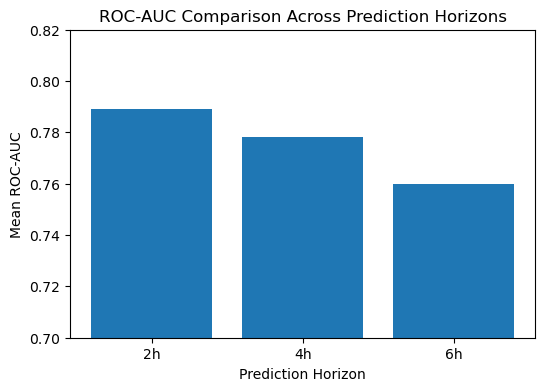

In [49]:
plt.figure(figsize=(6,4))
plt.bar(results_summary["Horizon"], results_summary["Mean ROC-AUC"])
plt.ylim(0.70, 0.82)
plt.title("ROC-AUC Comparison Across Prediction Horizons")
plt.ylabel("Mean ROC-AUC")
plt.xlabel("Prediction Horizon")
plt.show()

## Final Multi-Horizon Comparison Summary

The LSTM-based temporal model demonstrates consistent performance 
across all prediction horizons.

Performance trend:

2h  >  4h  >  6h

Mean ROC-AUC:
- 2h ≈ 0.789
- 4h ≈ 0.778
- 6h ≈ 0.760

Key Observations:

1. Temporal modeling improves upon logistic regression at all horizons.
2. Predictive signal is strongest closer to sepsis onset (2h).
3. Performance decreases as prediction horizon increases.
4. Model stability is high across random seeds (std < 0.01).

This confirms that short-term physiological deterioration patterns 
are more discriminative than earlier-stage signals.

The architecture and training protocol are now validated 
and will be used for feature importance and minimal feature set analysis.

In [50]:
# EXPORT PROCESSED TENSORS

from pathlib import Path
import torch
import joblib

EXPORT_PATH = Path("../Results/processed_tensors")
EXPORT_PATH.mkdir(parents=True, exist_ok=True)

print("Exporting processed tensors...\n")

# ---------- 2H ----------
torch.save(X_train_tensor.cpu(), EXPORT_PATH / "X_train_2h.pt")
torch.save(y_train_tensor.cpu(), EXPORT_PATH / "y_train_2h.pt")
torch.save(X_test_tensor.cpu(), EXPORT_PATH / "X_test_2h.pt")
torch.save(y_test_tensor.cpu(), EXPORT_PATH / "y_test_2h.pt")
joblib.dump(scaler, EXPORT_PATH / "scaler_2h.pkl")

# ---------- 4H ----------
torch.save(X_train_tensor_4h.cpu(), EXPORT_PATH / "X_train_4h.pt")
torch.save(y_train_tensor_4h.cpu(), EXPORT_PATH / "y_train_4h.pt")
torch.save(X_test_tensor_4h.cpu(), EXPORT_PATH / "X_test_4h.pt")
torch.save(y_test_tensor_4h.cpu(), EXPORT_PATH / "y_test_4h.pt")
joblib.dump(scaler_4h, EXPORT_PATH / "scaler_4h.pkl")

# ---------- 6H ----------
torch.save(X_train_tensor_6h.cpu(), EXPORT_PATH / "X_train_6h.pt")
torch.save(y_train_tensor_6h.cpu(), EXPORT_PATH / "y_train_6h.pt")
torch.save(X_test_tensor_6h.cpu(), EXPORT_PATH / "X_test_6h.pt")
torch.save(y_test_tensor_6h.cpu(), EXPORT_PATH / "y_test_6h.pt")
joblib.dump(scaler_6h, EXPORT_PATH / "scaler_6h.pkl")

print("Export complete.")
print("\nSaved files:")
for file in EXPORT_PATH.iterdir():
    print("-", file.name)

Exporting processed tensors...

Export complete.

Saved files:
- scaler_2h.pkl
- scaler_4h.pkl
- scaler_6h.pkl
- X_test_2h.pt
- X_test_4h.pt
- X_test_6h.pt
- X_train_2h.pt
- X_train_4h.pt
- X_train_6h.pt
- y_test_2h.pt
- y_test_4h.pt
- y_test_6h.pt
- y_train_2h.pt
- y_train_4h.pt
- y_train_6h.pt
